延用上週爬取的股價資料，完成本次作業要求：

1. 計算技術指標（SMA、RSI、MACD）

2. 可視化 K 線圖

3. 技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價

In [40]:
import requests
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams

In [119]:
stock_id = '2330'

# 定義從哪個月份開始抓取數據
start_year = 2024
start_month = 5

# 獲取當前日期，這樣可以設定查詢的終止月份
current_year = dt.date.today().year
current_month = dt.date.today().month

# 建立一個空的 DataFrame 來儲存所有月份的資料
all_data = pd.DataFrame()

# 循環遍歷每個月份，並抓取數據
for year in range(start_year, current_year + 1):
    # 確定循環的開始和結束月份
    month_start = start_month if year == start_year else 1
    month_end = current_month if year == current_year else 12

    for month in range(month_start, month_end + 1):
        # 格式化日期，格式為 YYYYMMDD（設定為該月的第一天）
        date_str = f"{year}{month:02d}01"

        # 抓取該月的股票數據
        stock_data = requests.get(f'https://www.twse.com.tw/rwd/zh/afterTrading/STOCK_DAY?date={date_str}&stockNo={stock_id}')
        json_data = stock_data.json()

        # 檢查 API 回傳的狀態是否成功
        if json_data['stat'] == 'OK':
            # 將該月的數據轉換為 DataFrame
            df = pd.DataFrame(data=json_data['data'], columns=json_data['fields'])

            # 民國年轉換為西元年
            def convert_minguo_to_gregorian(date_str):
                year, month, day = date_str.split('/')
                year = str(int(year) + 1911)
                return f'{year}/{month}/{day}'

            df['日期'] = df['日期'].apply(convert_minguo_to_gregorian)
            df['日期'] = pd.to_datetime(df['日期'], format='%Y/%m/%d')

            # 將數字格式的欄位轉換
            df['收盤價'] = pd.to_numeric(df['收盤價'].str.replace(',', ''), errors='coerce')
            df['開盤價'] = pd.to_numeric(df['開盤價'].str.replace(',', ''), errors='coerce')
            df['最高價'] = pd.to_numeric(df['最高價'].str.replace(',', ''), errors='coerce')
            df['最低價'] = pd.to_numeric(df['最低價'].str.replace(',', ''), errors='coerce')

            # 將該月的數據合併到 all_data 中
            all_data = pd.concat([all_data, df], ignore_index=True)

# 計算技術指標（SMA、RSI、MACD）
all_data['SMA_5'] = all_data['收盤價'].rolling(window=5).mean()  # 5日移動平均
all_data['SMA_20'] = all_data['收盤價'].rolling(window=20).mean()  # 20日移動平均
all_data['RSI_14'] = 100 - (100 / (1 + all_data['收盤價'].pct_change().rolling(window=14).apply(lambda x: (x[x > 0].mean() or 0) / -(x[x < 0].mean() or 0))))
all_data['MACD'] = all_data['收盤價'].ewm(span=12, adjust=False).mean() - all_data['收盤價'].ewm(span=26, adjust=False).mean()

# 移除含有 NaN 值的行
all_data.dropna(inplace=True)

# 顯示前幾行資料
all_data.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,SMA_5,SMA_20,RSI_14,MACD
19,2024-05-29,"51,073,346","43,924,367,680",861.0,868.0,856.0,857.0,-8.00,"67,680",866.6,828.50,60.764436,22.541550
20,2024-05-30,"42,535,118","35,840,589,611",841.0,848.0,838.0,838.0,-19.00,"110,390",859.2,831.80,53.801248,20.014035
21,2024-05-31,"90,177,283","74,602,358,441",838.0,846.0,821.0,821.0,-17.00,"102,070",850.0,833.85,47.380522,16.449582
22,2024-06-03,"29,629,706","25,053,781,742",839.0,853.0,837.0,846.0,+25.00,"40,694",845.4,836.85,53.991467,15.463762
23,2024-06-04,"31,031,104","26,107,162,214",844.0,851.0,837.0,839.0,-7.00,"52,392",840.2,838.80,54.316777,13.956766


# 可視化

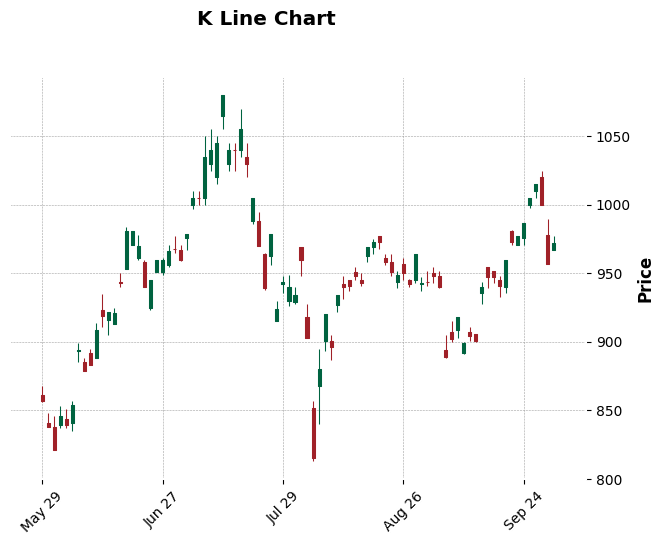

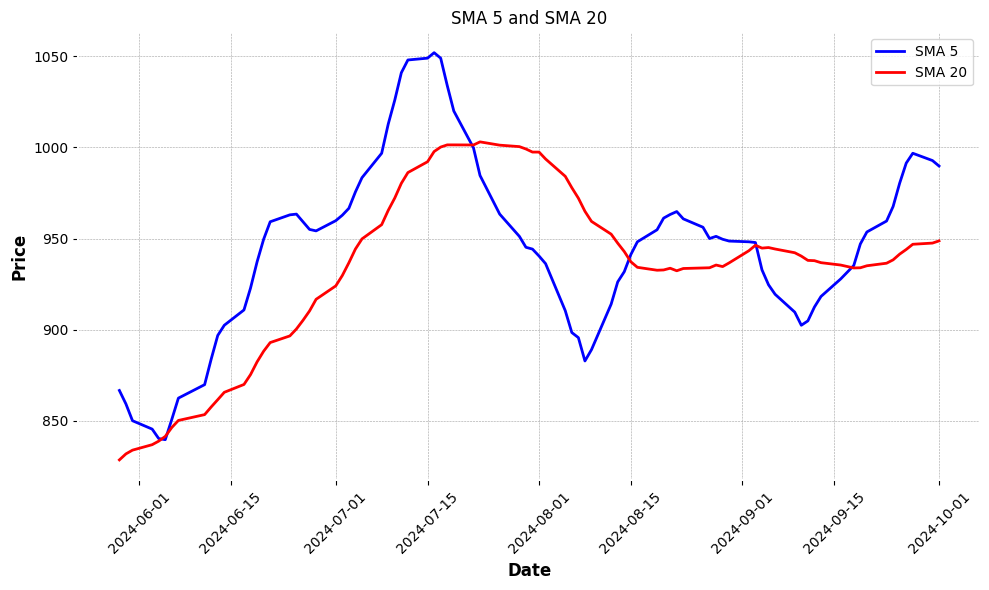

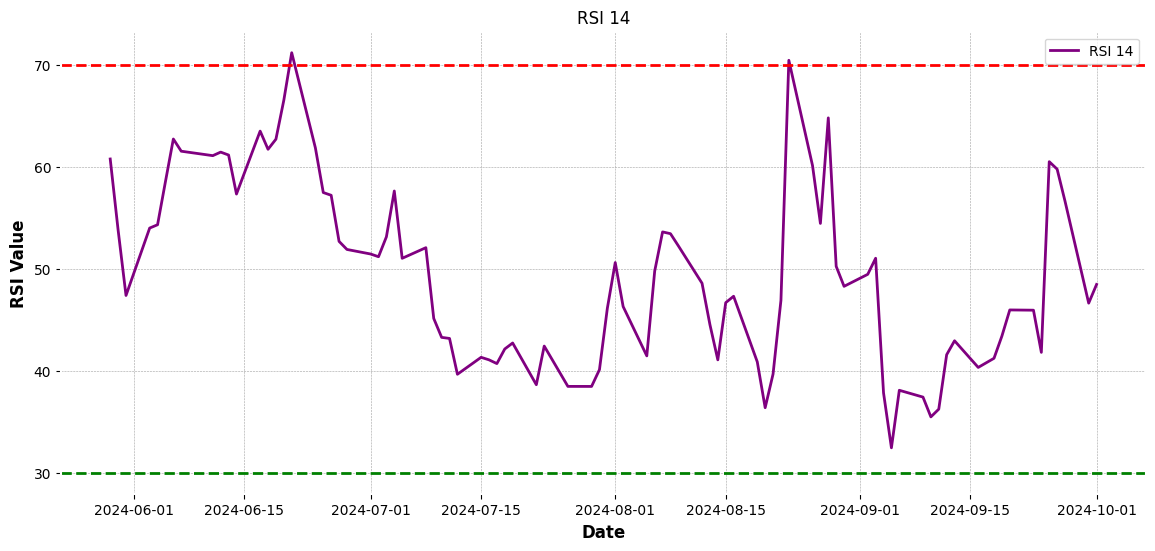

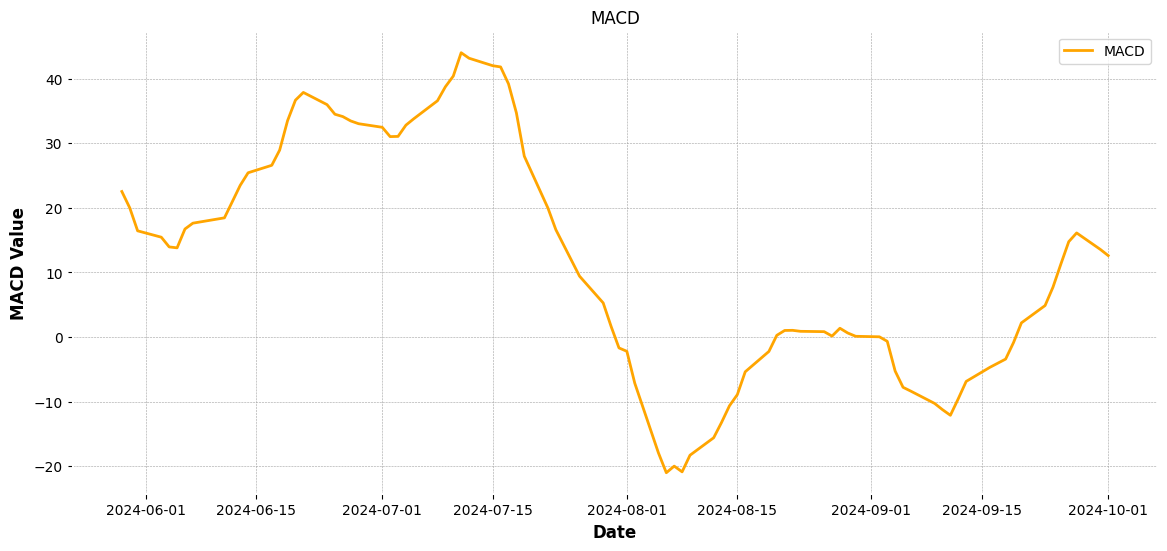

In [127]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd

# 將中文列名轉換為英文列名
k_data = all_data[['日期', '開盤價', '最高價', '最低價', '收盤價']].copy()
k_data.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '收盤價': 'Close'}, inplace=True)

# 確保日期是 DataFrame 的索引
k_data.set_index('日期', inplace=True)

# 1. 單獨繪製 K 線圖
mpf.plot(k_data, type='candle', style='charles',
         title='K Line Chart',
         ylabel='Price',
         volume=False)  # 如果不需要成交量，將 volume 設為 False

# 2. 單獨繪製 SMA_5 和 SMA_20 的圖表
plt.figure(figsize=(10, 6))

# 繪製 SMA_5 和 SMA_20
plt.plot(all_data['日期'], all_data['SMA_5'], label='SMA 5', color='blue')
plt.plot(all_data['日期'], all_data['SMA_20'], label='SMA 20', color='red')

plt.title('SMA 5 and SMA 20')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# 顯示 SMA 圖表
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. 繪製 RSI
plt.figure(figsize=(14, 6))
plt.plot(all_data['日期'], all_data['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, color='red', linestyle='--')  # 顯示 RSI 超買線
plt.axhline(30, color='green', linestyle='--')  # 顯示 RSI 超賣線
plt.title('RSI 14')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()

# 4. 繪製 MACD
plt.figure(figsize=(14, 6))
plt.plot(all_data['日期'], all_data['MACD'], label='MACD', color='orange')
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()

# 預測

Linear Regression MSE: 485.66538051319844
RandomForest Regression MSE: 503.1748000000004
XGBoost Regression MSE: 819.7934574006746
Polynomial Regression MSE (Degree 2): 1834.3530247906228


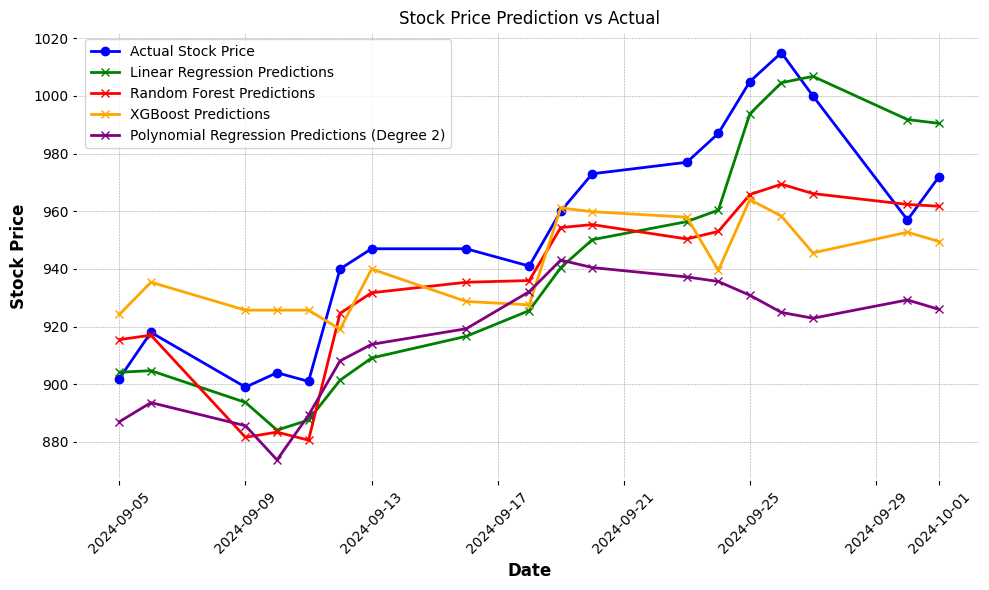

In [108]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# 提取日期
dates = all_data['日期']

# 提取特徵和標籤
features = ['SMA_5', 'SMA_20', 'RSI_14', 'MACD']
X = all_data[features]
y = all_data['收盤價']  # 使用實際的收盤價作為 y

# 分割訓練集和測試集，不打亂順序
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=42, shuffle=False)

# 使用機器學習模型進行訓練與預測
# 線性回歸模型
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
mse = mean_squared_error(y_test, lr_predictions)
print(f'Linear Regression MSE: {mse}')

# 隨機森林回歸
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
mse = mean_squared_error(y_test, rf_predictions)
print(f'RandomForest Regression MSE: {mse}')

#xgboost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=100)
xg_reg.fit(X_train, y_train)
xg_predictions = xg_reg.predict(X_test)
mse = mean_squared_error(y_test, xg_predictions)
print(f'XGBoost Regression MSE: {mse}')


# 多項式回歸
degree = 2  # 設定多項式的階數
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_poly, y_train)
poly_predictions = poly_reg_model.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, poly_predictions)
print(f'Polynomial Regression MSE (Degree {degree}): {mse_poly}')

# 繪製實際值與預測值的對比圖
plt.figure(figsize=(10, 6))

# 使用測試集中的日期作為 x 軸
plt.plot(dates_test, y_test.values, label='Actual Stock Price', color='blue', marker='o')

# 線性回歸模型的預測值
plt.plot(dates_test, lr_predictions, label='Linear Regression Predictions', color='green', marker='x')

# 隨機森林模型的預測值
plt.plot(dates_test, rf_predictions, label='Random Forest Predictions', color='red', marker='x')

# XGBoost 模型的預測值
plt.plot(dates_test, xg_predictions, label='XGBoost Predictions', color='orange', marker='x')

# 多項式回歸模型的預測值
plt.plot(dates_test, poly_predictions, label=f'Polynomial Regression Predictions (Degree {degree})', color='purple', marker='x')

# 添加圖例、標題和軸標籤
plt.title('Stock Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# 格式化日期顯示
plt.xticks(rotation=45)
plt.tight_layout()

# 顯示圖表
plt.show()